![](https://img.shields.io/badge/CNES_AVISO-Contribution-%20?color=grey&labelColor=blue)


# Subset SWOT LR L3 Unsmoothed data from AVISO's THREDDS Data Server
This notebooks explains how to retrieve a geographical subset of unsmoothed (250-m) SWOT LR L3 data on AVISO's THREDDS Data Server.

L3 Unsmoothed data can be explored at:

* https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/catalog.html

You need to have ``xarray``, ``numpy``, ``pydap``, ``threddsclient`` and ``matplotlib``+``cartopy`` (for visualisation) packages installed in your Python environment to execute this notebook.

<div class="alert alert-warning"><b>Warning</b><p>
 Threddsclient must be patched with adding the ``OPeNDAP`` name in the ``nodes.OPENDAP_SERVICE list`` as :
    OPENDAP_SERVICE = ["OPENDAP", "OpenDAP", "OPeNDAP"]
</p></div>

<div class="alert alert-warning"><b>Warning</b><p>
 This tutorial shows how to retrieve datasets via the Opendap protocol of the AVISO's THREDDS Data Server, that can be time consuming for large datasets. If you need to download large number of half orbits, please use the AVISO's FTP as in this [tutorial](https://swot-community.github.io/SWOT-galleries/SWOT-Oceanography/ex_download_subset_aviso_ftp.html).
</p></div>

## Tutorial Objectives
* Request Aviso's Thredds Data Server catalogue to find unsmoothed products
* Define a geographical area and cycles/passes numbers to subset data
* Download data locally and visualise it



## Import + code



In [1]:
# Install Cartopy with mamba to avoid discrepancies
# ! mamba install -q -c conda-forge cartopy

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
from getpass import getpass
import threddsclient
import numpy as np
import xarray as xr
from xarray.backends import PydapDataStore
import requests as rq
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [3]:
def retrieve_matching_datasets(url_catalogue, level, variant, cycle_min, cycle_max, half_orbits):
    """ Returns the list of datasets available in the catalogue, matching required half_orbits and cycles range.
    Args:
        url_catalogue: the catalogue
        level: swot LR data level ("L2", "L3")
        variant: Swot LR data variant ("Basic", "Expert", "Unsmoothed", "WindWave")
        cycle_min: minimum cycle
        cycle_max: maximum cycle
        half_orbits: list of passes numbers

    Returns:
        The list of matching dataset nodes.
    """
    import re

    def _swot_lr_filename_match(filename, level, variant, cycle_min, cycle_max, half_orbits):
        pattern = f'SWOT_{level}_LR_SSH_{variant}'
        match_object = re.match(pattern+r'_(\d+)_(\d+)_(.*)', filename)
    
        cycle_number = int(match_object.group(1))
        pass_number = int(match_object.group(2))
    
        return pass_number in half_orbits and cycle_number >= cycle_min and cycle_number <= cycle_max
    
    return list(filter(
        lambda dataset: (
            _swot_lr_filename_match(dataset.name, level, variant, cycle_min, cycle_max, half_orbits)),
        threddsclient.crawl(url_catalogue, depth=2)))
    
def open_dataset(dataset_url):
    """ Open the dataset at dataset_url.
    Args:
        dataset_url

    Returns:
        xr.Dataset
    """
    session = rq.Session()
    session.auth = (username, password)
    try:
        store = PydapDataStore.open(dataset_url, session=session, timeout=300, user_charset='UTF-8')
        return xr.open_dataset(store)
    except Exception as e:
        print(f"Something wrong with opendap url {dataset_url}: {e}")

def _open_dataset_coords(dataset_url):
    positions_url = dataset_url + '?' + ','.join(["latitude", "longitude", "latitude", "longitude"])
    ds_coords = open_dataset(positions_url)
    return ds_coords

def _get_indexes(ds, lon_range, lat_range):
    mask_left = ((ds["longitude"] >= lon_range[0]) & (ds["longitude"] <= lon_range[1]) &
    (ds["latitude"] >= lat_range[0]) & (ds["latitude"] <= lat_range[1]))
            
    mask_right = ((ds["longitude"] >= lon_range[0]) & (ds["longitude"] <= lon_range[1]) & 
    (ds["latitude"] >= lat_range[0]) & (ds["latitude"] <= lat_range[1]))

    mask = (mask_left | mask_right).any('num_pixels')

    return np.where(mask)[0][0], np.where(mask)[0][-1]
    
def _output_dir_prompt():
    answer = input('Do you want to write results to Netcdf files? [y/n]')
    if not answer or answer[0].lower() != 'y':
        return None
    return input('Enter existing directory:')

def load_subsets(matching_datasets, variables, lon_range, lat_range, output_dir=None):
    """ Loads subsets with variables and lon/lat range, and eventually write them to disk.
    Args:
        matching_datasets : the datasets nodes in the catalogue
        variables : the variables names
        lon_range : the longitude range
        lat_range : the latitude range
        output_dir : the output directory to write the datasets in separated netcdf files

    Returns:
        xr.Dataset
    """
    if not output_dir:
        output_dir = _output_dir_prompt()
    return [dataset for dataset in [_load_subset(dataset, variables, lon_range, lat_range, output_dir) for dataset in matching_datasets] if dataset is not None]
    
def _load_subset(dataset_node, variables, lon_range, lat_range, output_dir=None):
    if output_dir:
        output_file = os.path.join(output_dir, f"subset_{dataset_node.name}")
        if os.path.exists(output_file):
            print(f"Subset {dataset_node.name} already exists. Reading it...")
            return xr.open_dataset(output_file)
        
    # Open the dataset only with coordinates
    dataset_url = dataset_node.opendap_url()
    ds_positions = _open_dataset_coords(dataset_url)

    # Locate indexes of lines matching with the required geographical area
    try:
        idx_first, idx_last = _get_indexes(ds_positions, lon_range, lat_range)
    except IndexError:
        return None

    # Download subset    
    dataset = open_dataset(dataset_url)
        
    ds = xr.merge([dataset[var][idx_first:idx_last] for var in variables])
    print(f"Load intersection with selected area in dataset {dataset_node.name}: indices ({idx_first}, {idx_last})")
    ds.load()

    if output_file:
        ds.to_netcdf(output_file)
        print(f"File {output_file} created.")
        
    print('\n')
    return ds

## Parameters



### Authentication parameters
Enter your AVISO+ credentials



In [4]:
username = input("Enter username:")

Enter username: aviso-swot@altimetry.fr


In [5]:
password = getpass(f"Enter password for {username}:")

Enter password for aviso-swot@altimetry.fr: ········


### Data parameters

Define the variables you want:



In [13]:
variables = ['time', 'sigma0', 'ssha_unfiltered', 'quality_flag']

*OPTIONAL*
Define **existing** output folder to save results:



In [7]:
output_dir = "downloads"#or None

Define the url of the catalog from which you want to extract data

In [8]:
url_catalogue="https://tds.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Unsmoothed/catalog.html"
level = 'L3'
variant = 'Unsmoothed'

Define the parameters needed to retrieve data:

* geographical area
* phase: 1day-orbit (Calval) / 21day-orbit (Science)
* cycle min, max
* list of half-orbits

<div class="alert alert-info"><b>Note</b><p>Passes matching a geographical area and period can be found using this [tutorial](https://swot-community.github.io/SWOT-galleries/SWOT-Oceanography/ex_search_swot.html)</p></div>

In [9]:
# Mediterranean sea
lat_range = 25, 50
lon_range = -15, 40

#phase, cycle_min, cycle_max = "calval", 521, 521
#phase, cycle_min, cycle_max = "calval", 400, 600
phase, cycle_min, cycle_max = "science", 10, 12

half_orbits = [1, 3, 14]

## Area extraction
Gather datasets in the provided catalogue, matching the required cycles and half_orbits



In [10]:
matching_datasets = retrieve_matching_datasets(url_catalogue, level, variant, cycle_min, cycle_max, half_orbits)
'num datasets =', len(matching_datasets)

('num datasets =', 9)

In [11]:
matching_datasets

[<Node name: SWOT_L3_LR_SSH_Unsmoothed_012_014_20240307T045830_20240307T054956_v2.0.1.nc, content type: application/netcdf>,
 <Node name: SWOT_L3_LR_SSH_Unsmoothed_012_003_20240306T193234_20240306T202401_v2.0.1.nc, content type: application/netcdf>,
 <Node name: SWOT_L3_LR_SSH_Unsmoothed_012_001_20240306T174941_20240306T184108_v2.0.1.nc, content type: application/netcdf>,
 <Node name: SWOT_L3_LR_SSH_Unsmoothed_011_014_20240215T081326_20240215T090452_v2.0.1.nc, content type: application/netcdf>,
 <Node name: SWOT_L3_LR_SSH_Unsmoothed_011_003_20240214T224730_20240214T233857_v2.0.1.nc, content type: application/netcdf>,
 <Node name: SWOT_L3_LR_SSH_Unsmoothed_011_001_20240214T210437_20240214T215603_v2.0.1.nc, content type: application/netcdf>,
 <Node name: SWOT_L3_LR_SSH_Unsmoothed_010_014_20240125T112821_20240125T121947_v2.0.1.nc, content type: application/netcdf>,
 <Node name: SWOT_L3_LR_SSH_Unsmoothed_010_003_20240125T020226_20240125T025352_v2.0.1.nc, content type: application/netcdf>,


### Subset data in the required geographical area



<div class="alert alert-warning"><b>Warning</b><p>
 This operation may take some time : for each dataset, it downloads coordinates, calculates indices, loads subset and eventually writes it to netcdf file.</p></div>

Set ``output_dir`` to ``None`` if you don't want to write subsets to netcdf files.



In [14]:
datasets_subsets = load_subsets(matching_datasets, variables, lon_range, lat_range, output_dir)

Load intersection with selected area in dataset SWOT_L3_LR_SSH_Unsmoothed_012_014_20240307T045830_20240307T054956_v2.0.1.nc: indices (4820, 7982)
File downloads/subset_SWOT_L3_LR_SSH_Unsmoothed_012_014_20240307T045830_20240307T054956_v2.0.1.nc created.


Load intersection with selected area in dataset SWOT_L3_LR_SSH_Unsmoothed_012_001_20240306T174941_20240306T184108_v2.0.1.nc: indices (53119, 65300)
File downloads/subset_SWOT_L3_LR_SSH_Unsmoothed_012_001_20240306T174941_20240306T184108_v2.0.1.nc created.


Load intersection with selected area in dataset SWOT_L3_LR_SSH_Unsmoothed_011_014_20240215T081326_20240215T090452_v2.0.1.nc: indices (17691, 29825)
File downloads/subset_SWOT_L3_LR_SSH_Unsmoothed_011_014_20240215T081326_20240215T090452_v2.0.1.nc created.


Load intersection with selected area in dataset SWOT_L3_LR_SSH_Unsmoothed_011_001_20240214T210437_20240214T215603_v2.0.1.nc: indices (53129, 65311)
File downloads/subset_SWOT_L3_LR_SSH_Unsmoothed_011_001_20240214T210437_20240214T21

## Basic manipulations



### Concatenate subsets



In [15]:
all_ds = xr.concat(datasets_subsets, dim='num_lines')
all_ds

<xarray.Dataset> Size: 1GB
Dimensions:          (num_lines: 61399, num_pixels: 519)
Coordinates:
    latitude         (num_lines, num_pixels) float64 255MB 50.26 50.25 ... 50.0
    longitude        (num_lines, num_pixels) float64 255MB 1.326 1.322 ... 12.5
Dimensions without coordinates: num_lines, num_pixels
Data variables:
    time             (num_lines) datetime64[ns] 491kB 2024-03-07T05:09:27.887...
    sigma0           (num_lines, num_pixels) float64 255MB nan nan ... nan nan
    ssha_unfiltered  (num_lines, num_pixels) float64 255MB nan nan ... nan nan
    quality_flag     (num_lines, num_pixels) float32 127MB 102.0 102.0 ... 102.0
Attributes:
    comment:             Time of measurement in seconds in the UTC time scale...
    leap_second:         0000-00-00T00:00:00Z
    long_name:           time in UTC
    standard_name:       time
    tai_utc_difference:  37.0
    _ChunkSizes:         22921

### Visualize data



Select one dataset

In [16]:
ds = datasets_subsets[5]

Apply quality flag on Sigma 0

In [17]:
ds["sigma0"] = ds.sigma0.where(ds.quality_flag==0)

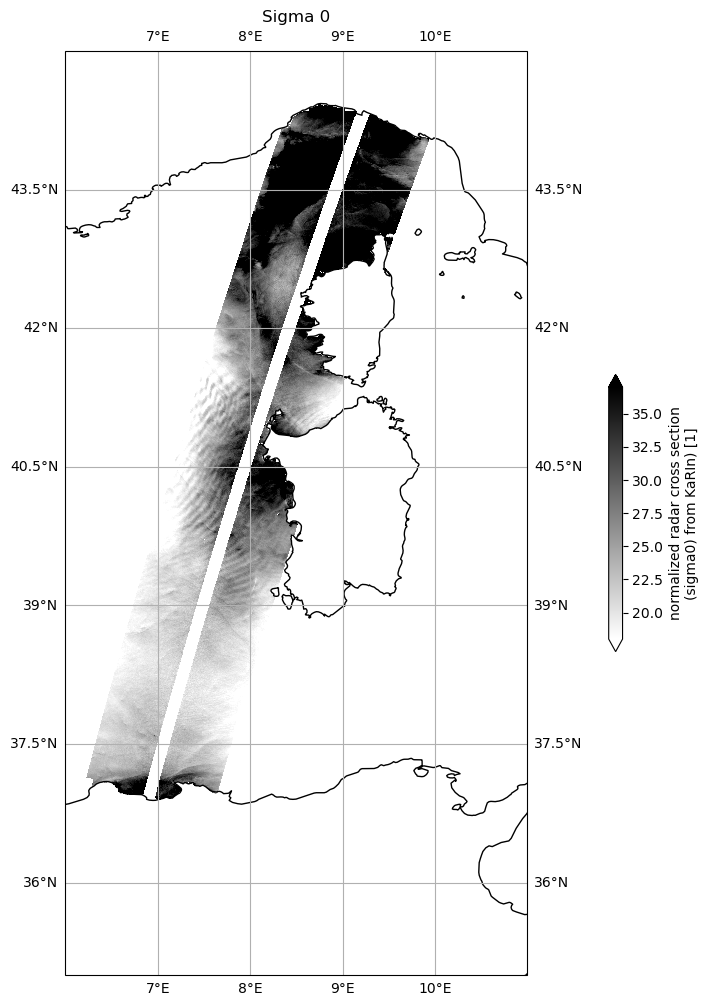

In [18]:
plot_kwargs = dict(
    x="longitude",
    y="latitude",
    cmap="gray_r",
    vmin=18,
    vmax=37,
)

fig, ax = plt.subplots(figsize=(21, 12), subplot_kw=dict(projection=ccrs.PlateCarree()))

ds.sigma0.plot.pcolormesh(ax=ax, cbar_kwargs={"shrink": 0.3}, **plot_kwargs)
plt.title("Sigma 0")

ax.gridlines(draw_labels=True)
ax.coastlines()
ax.set_extent([6, 11, 35, 45], crs=ccrs.PlateCarree())

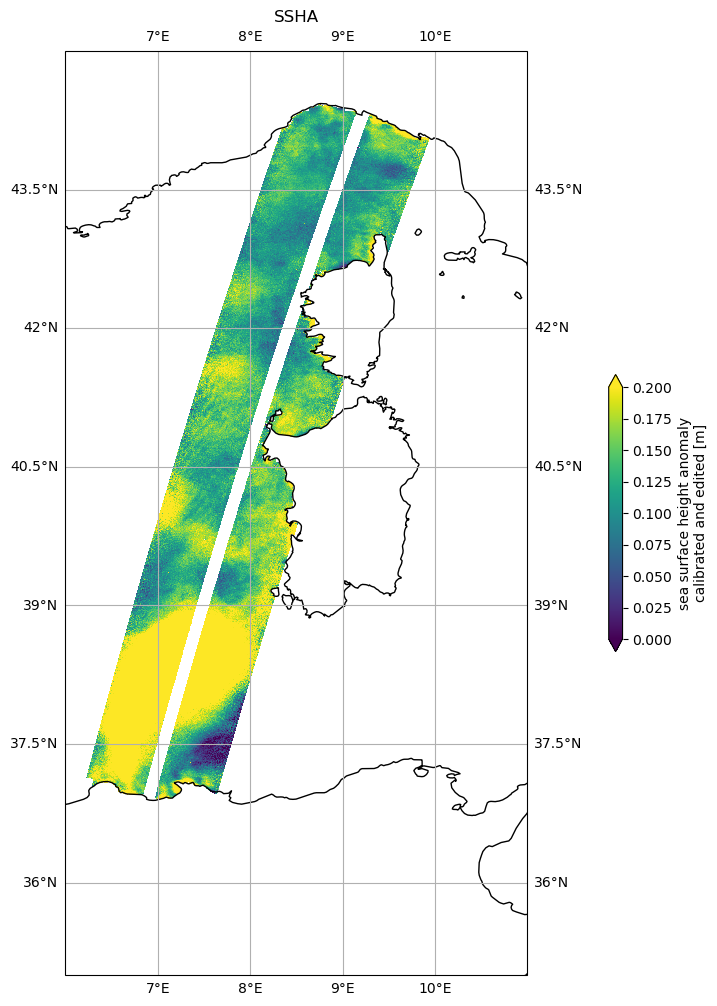

In [19]:
plot_kwargs = dict(
    x="longitude",
    y="latitude",
    vmin=0,
    vmax=0.2,
)

fig, ax = plt.subplots(figsize=(21, 12), subplot_kw=dict(projection=ccrs.PlateCarree()))

ds.ssha_unfiltered.plot.pcolormesh(ax=ax, cbar_kwargs={"shrink": 0.3}, **plot_kwargs)
plt.title('SSHA')

ax.gridlines(draw_labels=True)
ax.coastlines()
ax.set_extent([6, 11, 35, 45], crs=ccrs.PlateCarree())